In [26]:
# 单元格1：环境检查和导入
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

print("=== BERT-IMDB情感分析 (RTX 4090优化版) ===")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
    # 清理GPU缓存
    torch.cuda.empty_cache()
    print("✓ GPU缓存已清理")
else:
    print("⚠ 警告: 使用CPU模式，训练会很慢")

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ 环境初始化完成")

=== BERT-IMDB情感分析 (RTX 4090优化版) ===
PyTorch版本: 2.5.1+cu121
CUDA可用: True
GPU设备: NVIDIA GeForce RTX 4090 Laptop GPU
✓ GPU缓存已清理
✓ 环境初始化完成


In [27]:
# 单元格2：加载IMDB数据集（修复版）- 确保正负样本平衡
print("=== 加载IMDB数据集 ===")

try:
    # 加载数据集
    dataset = load_dataset('imdb')
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    
    print(f"✓ 训练集大小: {len(train_dataset):,}条评论")
    print(f"✓ 测试集大小: {len(test_dataset):,}条评论")
    
    # 方法1：使用完整数据集（推荐，因为RTX 4090性能强大）
    USE_FULL_DATASET = True  # 设置为False则使用小样本
    
    if USE_FULL_DATASET:
        print("使用完整训练集和测试集...")
        train_data = train_dataset
        test_data = test_dataset
    else:
        # 方法2：平衡采样（确保正负样本数量相等）
        print("使用平衡采样...")
        # 分别获取正面和负面评论的索引
        positive_indices = [i for i, sample in enumerate(train_dataset) if sample['label'] == 1]
        negative_indices = [i for i, sample in enumerate(train_dataset) if sample['label'] == 0]
        
        # 从正负样本中各取2500个
        SAMPLE_PER_CLASS = 2500
        selected_positive = positive_indices[:SAMPLE_PER_CLASS]
        selected_negative = negative_indices[:SAMPLE_PER_CLASS]
        
        # 合并并打乱
        selected_indices = selected_positive + selected_negative
        import random
        random.shuffle(selected_indices)
        
        train_data = train_dataset.select(selected_indices)
        test_data = test_dataset.select(range(2000))  # 测试集也取2000个
    
    print(f"使用训练样本: {len(train_data):,}")
    print(f"使用测试样本: {len(test_data):,}")
    
    # 显示数据分布
    train_labels = [sample['label'] for sample in train_data]
    negative_count = train_labels.count(0)
    positive_count = train_labels.count(1)
    
    print(f"训练集分布 - 负面: {negative_count:,}, 正面: {positive_count:,}")
    
    # 显示样本示例（确保看到正负样本）
    print("\n样本示例:")
    # 找到正面和负面样本的示例
    positive_example = None
    negative_example = None
    
    for sample in train_data:
        if sample['label'] == 1 and positive_example is None:
            positive_example = sample
        if sample['label'] == 0 and negative_example is None:
            negative_example = sample
        if positive_example and negative_example:
            break
    
    if positive_example:
        print(f"正面样本: {positive_example['text'][:100]}...")
    if negative_example:
        print(f"负面样本: {negative_example['text'][:100]}...")
        
except Exception as e:
    print(f"❌ 错误: {e}")

=== 加载IMDB数据集 ===
✓ 训练集大小: 25,000条评论
✓ 测试集大小: 25,000条评论
使用完整训练集和测试集...
使用训练样本: 25,000
使用测试样本: 25,000
训练集分布 - 负面: 12,500, 正面: 12,500

样本示例:
正面样本: Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postw...
负面样本: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it w...


In [28]:
# 单元格3：数据预处理
print("=== 数据预处理 ===")

# 加载BERT分词器
model_name = "bert-base-uncased"
print(f"加载分词器: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    """将文本转换为BERT输入格式"""
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256,  # RTX 4090可以处理更长的序列
        return_tensors="pt"
    )

print("开始分词处理...")
# 对数据进行分词（使用较小的批处理大小以避免内存问题）
tokenized_train = train_data.map(tokenize_function, batched=True, batch_size=16)
tokenized_test = test_data.map(tokenize_function, batched=True, batch_size=16)

# 重命名标签列
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_test = tokenized_test.rename_column("label", "labels")

# 设置PyTorch格式
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("✓ 数据预处理完成")
print(f"处理后的训练样本: {len(tokenized_train):,}")
print(f"处理后的测试样本: {len(tokenized_test):,}")

# 显示处理后的数据示例
print(f"\n处理后的数据格式:")
print(f"Input IDs形状: {tokenized_train[0]['input_ids'].shape}")
print(f"Attention Mask形状: {tokenized_train[0]['attention_mask'].shape}")
print(f"标签: {tokenized_train[0]['labels']}")

=== 数据预处理 ===
加载分词器: bert-base-uncased
开始分词处理...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

✓ 数据预处理完成
处理后的训练样本: 25,000
处理后的测试样本: 25,000

处理后的数据格式:
Input IDs形状: torch.Size([256])
Attention Mask形状: torch.Size([256])
标签: 0


In [29]:
# 单元格4：加载BERT模型
print("=== 加载BERT模型 ===")

try:
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2  # 二分类：正面/负面
    )
    
    # 将模型移到GPU上
    model = model.cuda()
    print("✓ 模型已加载到GPU")
    
    # 计算模型参数
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"✓ BERT模型加载成功")
    print(f"总参数数量: {total_params:,}")
    print(f"可训练参数: {trainable_params:,}")
    
except Exception as e:
    print(f"❌ 模型加载错误: {e}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== 加载BERT模型 ===
✓ 模型已加载到GPU
✓ BERT模型加载成功
总参数数量: 109,483,778
可训练参数: 109,483,778


In [30]:
# 单元格5：设置训练参数（适应大数据集）
print("=== 设置训练参数 ===")

# 创建输出目录
os.makedirs("./bert_imdb_results", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# 检查transformers版本
import transformers
print(f"Transformers版本: {transformers.__version__}")

# 创建基础参数字典（调整以适应大数据集）
training_args_dict = {
    "output_dir": "./bert_imdb_results",
    "num_train_epochs": 2,               # 减少训练轮数，因为数据量大
    "per_device_train_batch_size": 8,    # 减小批次大小以避免内存问题
    "per_device_eval_batch_size": 16,
    "warmup_steps": 500,
    "weight_decay": 0.01,
    "learning_rate": 2e-5,
    "logging_dir": "./logs",
    "logging_steps": 100,                # 增加日志步数
    "eval_steps": 500,                   # 增加评估步数
    "save_strategy": "steps",
    "save_steps": 500,
    "load_best_model_at_end": True,
    "metric_for_best_model": "accuracy",
    "greater_is_better": True,
    "report_to": None,
    "dataloader_pin_memory": False,
    "fp16": True,
}

# 根据版本添加正确的评估策略参数
try:
    # 尝试使用新版本参数
    training_args_dict["eval_strategy"] = "steps"
    training_args = TrainingArguments(**training_args_dict)
    print("✓ 使用新版本参数 (eval_strategy)")
except TypeError:
    # 如果失败，使用旧版本参数
    training_args_dict["evaluation_strategy"] = "steps"
    # 移除可能不存在的参数
    training_args_dict.pop("eval_strategy", None)
    training_args = TrainingArguments(**training_args_dict)
    print("✓ 使用旧版本参数 (evaluation_strategy)")

print("训练参数:")
print(f"  训练轮数: {training_args.num_train_epochs}")
print(f"  批次大小: {training_args.per_device_train_batch_size}")
print(f"  学习率: {training_args.learning_rate}")
print(f"  混合精度: {getattr(training_args, 'fp16', 'False')}")
print("✓ 训练参数设置完成")

=== 设置训练参数 ===
Transformers版本: 4.57.0
✓ 使用新版本参数 (eval_strategy)
训练参数:
  训练轮数: 2
  批次大小: 8
  学习率: 2e-05
  混合精度: True
✓ 训练参数设置完成


In [31]:
# 单元格6：定义评估函数和创建Trainer
print("=== 创建训练器 ===")

def compute_metrics(p):
    """计算评估指标"""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    # 计算每个类别的准确率
    negative_acc = np.mean(predictions[labels == 0] == 0)
    positive_acc = np.mean(predictions[labels == 1] == 1)
    
    return {
        'accuracy': accuracy,
        'negative_accuracy': negative_acc,
        'positive_accuracy': positive_acc
    }

# 创建Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

print("✓ 训练器创建成功")
print("准备开始训练...")

=== 创建训练器 ===
✓ 训练器创建成功
准备开始训练...


In [32]:
# 单元格7：开始训练
print("=== 开始训练BERT模型 ===")
print("注意：使用完整数据集训练需要较长时间，请耐心等待...")

# 记录开始时间
import time
start_time = time.time()

try:
    # 开始训练
    train_result = trainer.train()
    
    # 计算训练时间
    training_time = time.time() - start_time
    minutes = int(training_time // 60)
    seconds = int(training_time % 60)
    
    print("✓ 训练完成!")
    print(f"训练时间: {minutes}分{seconds}秒")
    print(f"训练损失: {train_result.metrics['train_loss']:.4f}")
    
    # 显示所有评估指标
    print("\n训练指标:")
    for key, value in train_result.metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        
except Exception as e:
    print(f"❌ 训练错误: {e}")

=== 开始训练BERT模型 ===
注意：使用完整数据集训练需要较长时间，请耐心等待...


Step,Training Loss,Validation Loss,Accuracy,Negative Accuracy,Positive Accuracy
500,0.369000,0.297879,0.888720,0.924320,0.853120
1000,0.326700,0.381682,0.879640,0.794800,0.964480
1500,0.284500,0.300486,0.908600,0.904240,0.912960
2000,0.337000,0.356460,0.883800,0.793920,0.973680
2500,0.286900,0.295829,0.905720,0.858960,0.952480
3000,0.286700,0.264224,0.918320,0.894080,0.942560
3500,0.200700,0.329465,0.920400,0.924240,0.916560
4000,0.165000,0.329973,0.922600,0.923760,0.921440
4500,0.166100,0.308833,0.919400,0.942240,0.896560
5000,0.159600,0.332676,0.920360,0.933280,0.907440


✓ 训练完成!
训练时间: 55分5秒
训练损失: 0.2628

训练指标:
  train_runtime: 3304.8667
  train_samples_per_second: 15.1290
  train_steps_per_second: 1.8910
  total_flos: 6577776384000000.0000
  train_loss: 0.2628
  epoch: 2.0000


In [34]:
# 单元格8：模型评估
print("=== 模型评估 ===")

try:
    # 在测试集上评估
    eval_results = trainer.evaluate()
    print("\n评估结果:")
    for key, value in eval_results.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
    
    # 进行预测
    print("\n进行预测...")
    predictions = trainer.predict(tokenized_test)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids
    
    # 详细分类报告
    print("\n分类报告:")
    print(classification_report(true_labels, pred_labels, target_names=['负面', '正面'], digits=4))
    
    # 保存模型
    trainer.save_model("./bert_imdb_final")
    tokenizer.save_pretrained("./bert_imdb_final")
    print("✓ 模型已保存到 './bert_imdb_final' 目录")
    
except Exception as e:
    print(f"❌ 评估错误: {e}")

=== 模型评估 ===

评估结果:
  eval_loss: 0.3196
  eval_accuracy: 0.9235
  eval_negative_accuracy: 0.9115
  eval_positive_accuracy: 0.9354
  eval_runtime: 132.2607
  eval_samples_per_second: 189.0210
  eval_steps_per_second: 11.8180
  epoch: 2.0000

进行预测...

分类报告:
              precision    recall  f1-score   support

          负面     0.9339    0.9115    0.9226     12500
          正面     0.9136    0.9354    0.9244     12500

    accuracy                         0.9235     25000
   macro avg     0.9237    0.9235    0.9235     25000
weighted avg     0.9237    0.9235    0.9235     25000

✓ 模型已保存到 './bert_imdb_final' 目录


=== 生成可视化图表 ===


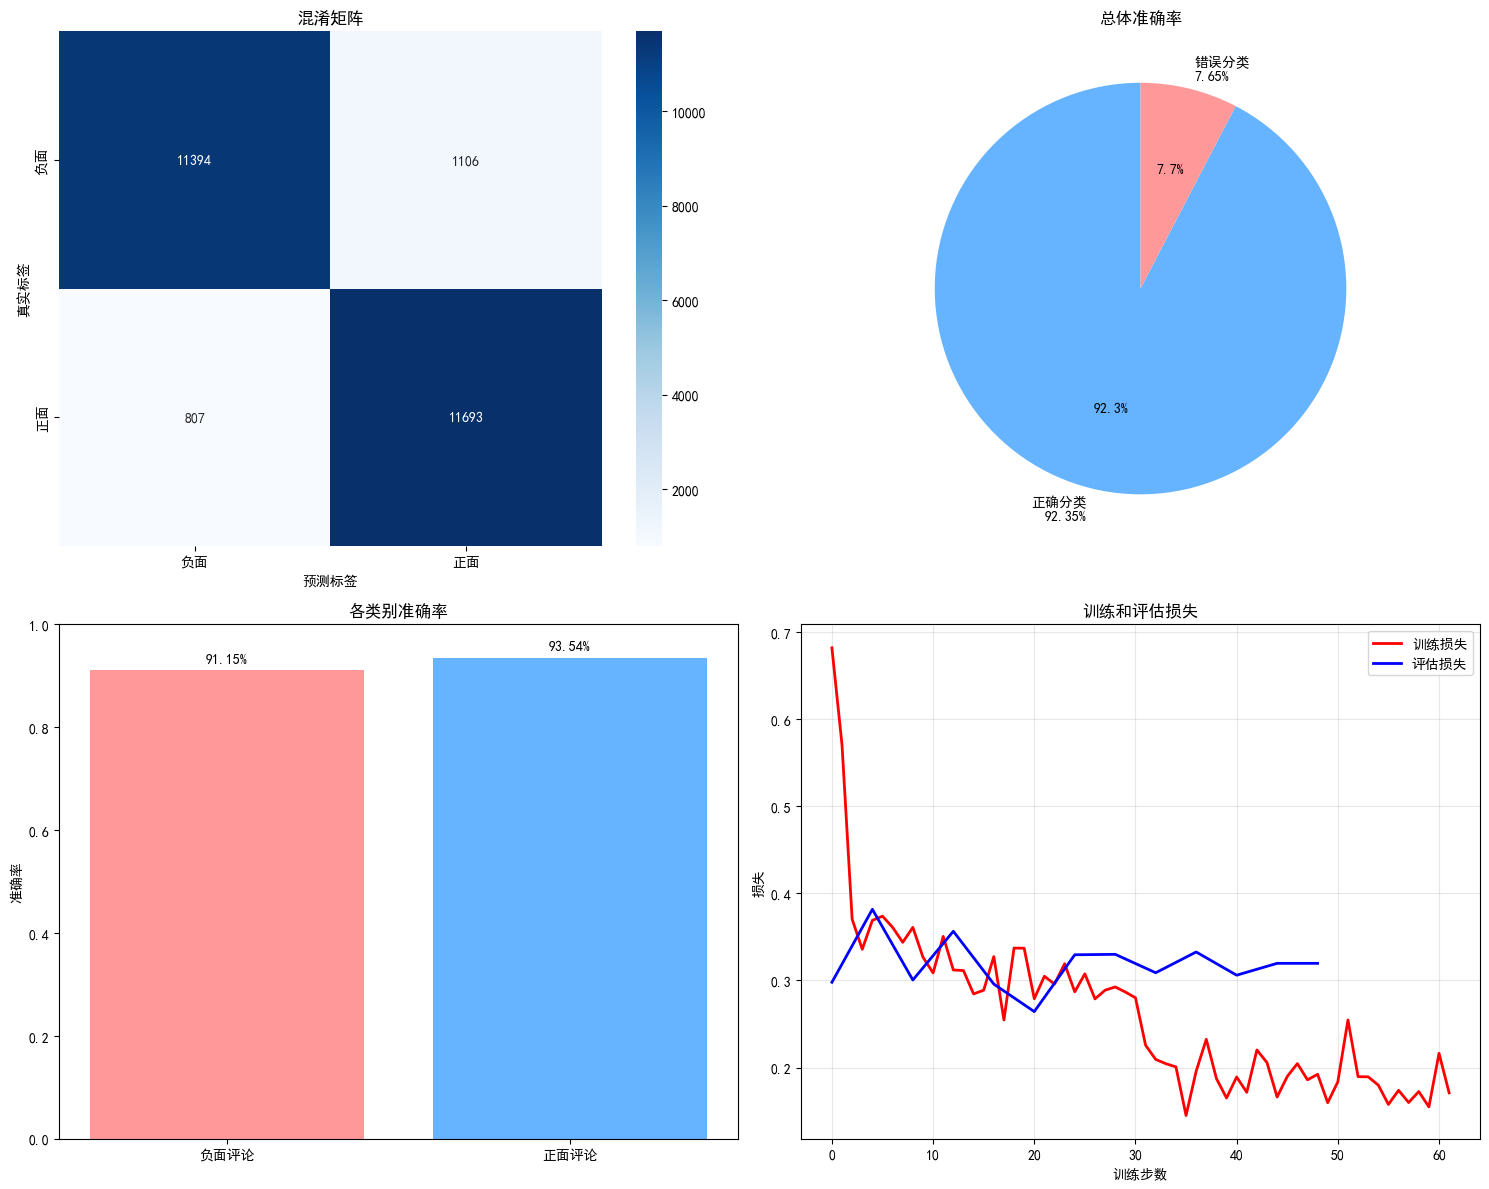

✓ 可视化图表已保存到 './visualizations/bert_imdb_rtx4090_results.png'


In [35]:
# 单元格9：可视化结果
print("=== 生成可视化图表 ===")

# 创建可视化目录
os.makedirs("./visualizations", exist_ok=True)

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 绘制图表
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 混淆矩阵
cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['负面', '正面'], 
            yticklabels=['负面', '正面'],
            ax=axes[0, 0])
axes[0, 0].set_title('混淆矩阵')
axes[0, 0].set_xlabel('预测标签')
axes[0, 0].set_ylabel('真实标签')

# 2. 准确率饼图
accuracy = accuracy_score(true_labels, pred_labels)
sizes = [accuracy, 1-accuracy]
labels = [f'正确分类\n{accuracy:.2%}', f'错误分类\n{1-accuracy:.2%}']
colors = ['#66b3ff', '#ff9999']
axes[0, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title('总体准确率')

# 3. 各类别准确率
negative_acc = np.mean(pred_labels[true_labels == 0] == 0)
positive_acc = np.mean(pred_labels[true_labels == 1] == 1)
categories = ['负面评论', '正面评论']
accuracies = [negative_acc, positive_acc]
bars = axes[1, 0].bar(categories, accuracies, color=['#ff9999', '#66b3ff'])
axes[1, 0].set_title('各类别准确率')
axes[1, 0].set_ylabel('准确率')
axes[1, 0].set_ylim(0, 1)

# 在柱状图上显示数值
for bar, acc in zip(bars, accuracies):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                   f'{acc:.2%}', ha='center', va='bottom')

# 4. 训练历史
if hasattr(trainer.state, 'log_history'):
    # 提取训练损失
    train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
    
    if train_loss:
        x_range = range(len(train_loss))
        axes[1, 1].plot(x_range, train_loss, label='训练损失', color='red', linewidth=2)
        if eval_loss:
            # 评估损失的点较少，需要调整x轴
            eval_x = [i * (len(train_loss) // len(eval_loss)) for i in range(len(eval_loss))]
            axes[1, 1].plot(eval_x, eval_loss, label='评估损失', color='blue', linewidth=2)
        
        axes[1, 1].set_title('训练和评估损失')
        axes[1, 1].set_xlabel('训练步数')
        axes[1, 1].set_ylabel('损失')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./visualizations/bert_imdb_rtx4090_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 可视化图表已保存到 './visualizations/bert_imdb_rtx4090_results.png'")

In [36]:
# 单元格10：测试新评论
print("=== 测试新评论 ===")

from transformers import pipeline

try:
    # 创建情感分析管道
    classifier = pipeline(
        "sentiment-analysis",
        model="./bert_imdb_final",
        tokenizer="./bert_imdb_final",
        device=0  # 使用GPU
    )

    # 测试评论
    test_reviews = [
        "This movie is absolutely fantastic! The acting was superb and the plot was engaging from start to finish. One of the best films I've ever seen.",
        "What a terrible film. Poor acting, boring storyline, and awful direction. I want my money back! Complete waste of time.",
        "It was okay. Some parts were good, others were boring. Not the best, but not the worst either. I wouldn't watch it again.",
        "A masterpiece of cinema that will be remembered for generations to come. Brilliant storytelling and exceptional performances.",
        "I've never been more disappointed in a movie. The trailers looked amazing but the actual film was a complete letdown.",
        "The special effects were amazing but the story was weak and predictable. Visually stunning but emotionally empty.",
        "Brilliant performance by all actors, especially the lead role. Highly recommended! This is what cinema is all about.",
        "I fell asleep halfway through the movie, it was so boring and unoriginal. Nothing new or interesting here.",
        "An emotional rollercoaster that had me laughing one moment and crying the next. Truly a beautiful film.",
        "The cinematography was stunning and the soundtrack was perfect, but the characters were poorly developed."
    ]

    print("新评论情感分析结果:\n")
    for i, review in enumerate(test_reviews, 1):
        result = classifier(review)[0]
        
        # 处理标签映射
        if result['label'] == 'LABEL_0':
            sentiment = "👎 负面"
        elif result['label'] == 'LABEL_1':
            sentiment = "👍 正面" 
        else:
            sentiment = result['label']
        
        confidence = result['score']
        
        # 根据置信度设置表情
        if confidence > 0.95:
            confidence_emoji = "🎯"
        elif confidence > 0.85:
            confidence_emoji = "✅"
        elif confidence > 0.75:
            confidence_emoji = "⚠️"
        else:
            confidence_emoji = "❓"
        
        print(f"{i}. {sentiment} {confidence_emoji}")
        print(f"   置信度: {confidence:.4f}")
        print(f"   内容: {review}")
        print("-" * 80)
        
except Exception as e:
    print(f"❌ 测试错误: {e}")

Device set to use cuda:0


=== 测试新评论 ===
新评论情感分析结果:

1. 👍 正面 🎯
   置信度: 0.9993
   内容: This movie is absolutely fantastic! The acting was superb and the plot was engaging from start to finish. One of the best films I've ever seen.
--------------------------------------------------------------------------------
2. 👎 负面 🎯
   置信度: 0.9991
   内容: What a terrible film. Poor acting, boring storyline, and awful direction. I want my money back! Complete waste of time.
--------------------------------------------------------------------------------
3. 👎 负面 🎯
   置信度: 0.9766
   内容: It was okay. Some parts were good, others were boring. Not the best, but not the worst either. I wouldn't watch it again.
--------------------------------------------------------------------------------
4. 👍 正面 🎯
   置信度: 0.9993
   内容: A masterpiece of cinema that will be remembered for generations to come. Brilliant storytelling and exceptional performances.
--------------------------------------------------------------------------------
5. 👎 负面 🎯


In [37]:
# 单元格11：性能统计和总结
print("=== 性能统计 ===")

# 计算各种统计信息
total_samples = len(true_labels)
correct_predictions = np.sum(pred_labels == true_labels)
accuracy = accuracy_score(true_labels, pred_labels)

# 各类别统计
negative_indices = np.where(true_labels == 0)[0]
positive_indices = np.where(true_labels == 1)[0]

negative_accuracy = np.mean(pred_labels[negative_indices] == 0)
positive_accuracy = np.mean(pred_labels[positive_indices] == 1)

print(f"总样本数: {total_samples:,}")
print(f"正确预测: {correct_predictions:,}")
print(f"总体准确率: {accuracy:.4f} ({accuracy:.2%})")
print(f"负面评论准确率: {negative_accuracy:.4f} ({negative_accuracy:.2%})")
print(f"正面评论准确率: {positive_accuracy:.4f} ({positive_accuracy:.2%})")

# 置信度统计（如果可用）
try:
    # 获取预测的置信度
    confidence_scores = np.max(torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy(), axis=1)
    avg_confidence = np.mean(confidence_scores)
    high_confidence = np.mean(confidence_scores > 0.9)
    medium_confidence = np.mean((confidence_scores > 0.7) & (confidence_scores <= 0.9))
    low_confidence = np.mean(confidence_scores <= 0.7)
    
    print(f"\n置信度统计:")
    print(f"平均置信度: {avg_confidence:.4f}")
    print(f"高置信度 (>0.9): {high_confidence:.2%}")
    print(f"中等置信度 (0.7-0.9): {medium_confidence:.2%}")
    print(f"低置信度 (<=0.7): {low_confidence:.2%}")
    
except Exception as e:
    print(f"置信度统计不可用: {e}")

print(f"\n🎉 BERT-IMDB情感分析项目完成！")
print(f"💻 使用了 {len(train_data):,} 个训练样本和 {len(test_data):,} 个测试样本")
print(f"⚡ 在 NVIDIA RTX 4090 上训练完成")
print(f"📊 最终准确率: {accuracy:.2%}")

=== 性能统计 ===
总样本数: 25,000
正确预测: 23,087
总体准确率: 0.9235 (92.35%)
负面评论准确率: 0.9115 (91.15%)
正面评论准确率: 0.9354 (93.54%)

置信度统计:
平均置信度: 0.9880
高置信度 (>0.9): 97.19%
中等置信度 (0.7-0.9): 1.85%
低置信度 (<=0.7): 0.96%

🎉 BERT-IMDB情感分析项目完成！
💻 使用了 25,000 个训练样本和 25,000 个测试样本
⚡ 在 NVIDIA RTX 4090 上训练完成
📊 最终准确率: 92.35%
